In [21]:
import os
 
def set_dir(path):
    os.chdir(path)
    print(f"Working directory is now: {os.getcwd()}")
    
print(f"Working directory is now: {os.getcwd()}")
current_dir = os.path.dirname('/home/lunxu/yangqh/FEN/Linear/PoissonHD/tanhELM/')
set_dir(current_dir)

Working directory is now: /home/lunxu/yangqh/FEN/Linear/PoissonHD/FourierNet
Working directory is now: /home/lunxu/yangqh/FEN/Linear/PoissonHD/FourierNet


In [22]:
import logging
import sys
from pyDOE import lhs
import torch
import torch.nn as nn   
from init_config import *
from train_config import *
from model import INIT_TYPE, MODEL_NAME

# 打印相关信息
def log(obj):
    print(obj)
    logging.info(obj)

In [23]:
# cuda 调用
device = 'cuda'
# 设置需要写日志
init_log()

param_dict = {
    'lb': lb,
    'ub': ub,
    'device': device,
    'path': path,
    'root_path': root_path,
}

### 生成训练点 ####

# 区域内采点数
if d==5:
    N_B = 100
    N_R = 10000
    N_basis = 10000
    block_num = 2
elif d==10:
    N_B = 100
    N_R = 10000
    N_basis = 2500
    block_num = 2
else:
    N_R = 10000
    N_B = 40
    N_basis = 2500
    block_num = 2
# lhs采样 size=[2,N_f]
x = lb + (ub-lb)*lhs(d, N_R)

x_b = []
if d==1:
    x_b.append(lb[0])
    x_b.append(ub[0])
    x_b = np.array(x_b).reshape(2, 1)
else:
    for i in range(d):
        x_bi =  lb[i] + (ub[i]-lb[i])*lhs(d-1, N_B)
        x_bi0 = np.insert(x_bi, i, lb[i], axis=1)
        x_bi1 = np.insert(x_bi, i, ub[i], axis=1)
        x_b.append(x_bi0)
        x_b.append(x_bi1)
    x_b = np.array(x_b).reshape(N_B * d * 2, d)

N_basis = N_basis
in_num = d
out_num = N_basis
layer_num = N_basis

# 打印参数
log_str = 'd ' + str(d) + ' N_R '+str(N_R) + ' N_B '+str(N_B) + ' N_basis ' + str(N_basis)
log(log_str)

# 训练参数
train_dict = {
    'x': x,
    'x_b': x_b,
    'funF': funF,
    'funU': funU,
    'N_basis': N_basis,
}

d 5 N_R 10000 N_B 100 N_basis 10000


In [24]:
def train_Adam(model, device, scale, param_dict, train_dict, Adam_steps=50000,  Adam_init_lr=1e-3, scheduler_name=None, scheduler_params=None):
    '''
    用Adam训练
    '''
    # 记录时间
    start_time = time.time()
    model.scale = nn.Parameter(torch.ones((1, 1))*scale)
    model.to(device)
    model_config = PINNConfig(param_dict=param_dict,
                              train_dict=train_dict, model=model)
    # 用Adam训练
    if model_config.params is not None:
        params = model_config.params
    else:
        params = model.parameters()
    model_config.train_Adam(params=params, Adam_steps=Adam_steps, Adam_init_lr=Adam_init_lr,
                            scheduler_name=scheduler_name, scheduler_params=scheduler_params)
    # 打印总耗时
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    logging.info('Training time: %.4f' % (elapsed))

In [25]:
step = 0.0001
stop = 5000
Ns = [400, 900, 1600, 2500]
for N_basis in Ns:
    out_num = N_basis
    train_dict['N_basis'] = N_basis
    layers = [in_num, out_num]
    # layers = [in_num, layer_num, layer_num, layer_num, out_num]
    model_name = MODEL_NAME.tanhELM
    model_dict = {
        'layers': layers,
        'init_type': INIT_TYPE.Uniform,
        'init_params':{
            'var': 1
        }
    }
    # 获取神经网络模型
    model = get_model(model_dict, model_name)
    log(model_dict)
    for i in range(1, stop+1):
        scale = i * step
        log('N_basis ' +str(N_basis) + ' scale ' + str(scale))
        train_Adam(model, device, scale, param_dict, train_dict, Adam_steps=1)

{'layers': [5, 400], 'init_type': 'uniform', 'init_params': {'var': 1}}
N_basis 400 scale 0.0001
Time: 0.0011s for 1 -th batch
Time: 0.0009s for 2 -th batch
Time: 0.0009s for 3 -th batch
Time: 0.0009s for 4 -th batch
Time: 0.0009s for 5 -th batch
Time: 0.0009s for 6 -th batch
Time: 0.0009s for 7 -th batch
Time: 0.0009s for 8 -th batch
Time: 0.0009s for 9 -th batch
Time: 0.0009s for 10 -th batch
Elapsed Time: 0.0235s
u_infty 1.6014466661662397e-05 u_rel_l2 1.0592609699968548e-05
u_infty 1.151339598470802e-05 u_rel_l2 9.585720719713074e-06
loss_infty 0.00033907177051950566 loss_rel_l2 2.4218692211766637e-05
Time: 0.0248s Per 1 Iterators
Training time: 0.0393
N_basis 400 scale 0.0002
Time: 0.0010s for 1 -th batch
Time: 0.0009s for 2 -th batch
Time: 0.0009s for 3 -th batch
Time: 0.0009s for 4 -th batch
Time: 0.0009s for 5 -th batch
Time: 0.0009s for 6 -th batch
Time: 0.0009s for 7 -th batch
Time: 0.0009s for 8 -th batch
Time: 0.0009s for 9 -th batch
Time: 0.0009s for 10 -th batch
Elapsed T

KeyboardInterrupt: 

In [16]:
# 日志读取
u_inftys = []
u_rel_l2s = []
loss_inftys = []
loss_rel_l2s = []

PINN_log_path = root_path + '/' + path + '/log.txt'

# step值越过多少个点再记录
def read_PINN_log(PINN_log_path, step=1):
    with open(PINN_log_path, 'r') as fs:
        line_num = 0
        while True:
            line = fs.readline()  # 整行读取数据
            if not line:
                break
            datas = line.replace('\n', '').split('INFO:root:')[-1].split(' ')
            if datas is not None:
                if datas[0] == 'u_infty':
                    u_inftys.append(float(datas[1]))
                if datas[2] == 'u_rel_l2':
                    u_rel_l2s.append(float(datas[3]))
                if datas[0] == 'loss_infty':
                    loss_inftys.append(float(datas[1]))
                if datas[2] == 'loss_rel_l2':
                    loss_rel_l2s.append(float(datas[3]))

read_PINN_log(PINN_log_path)

u_inftys = u_inftys[::2]
u_rel_l2s = u_rel_l2s[::2]

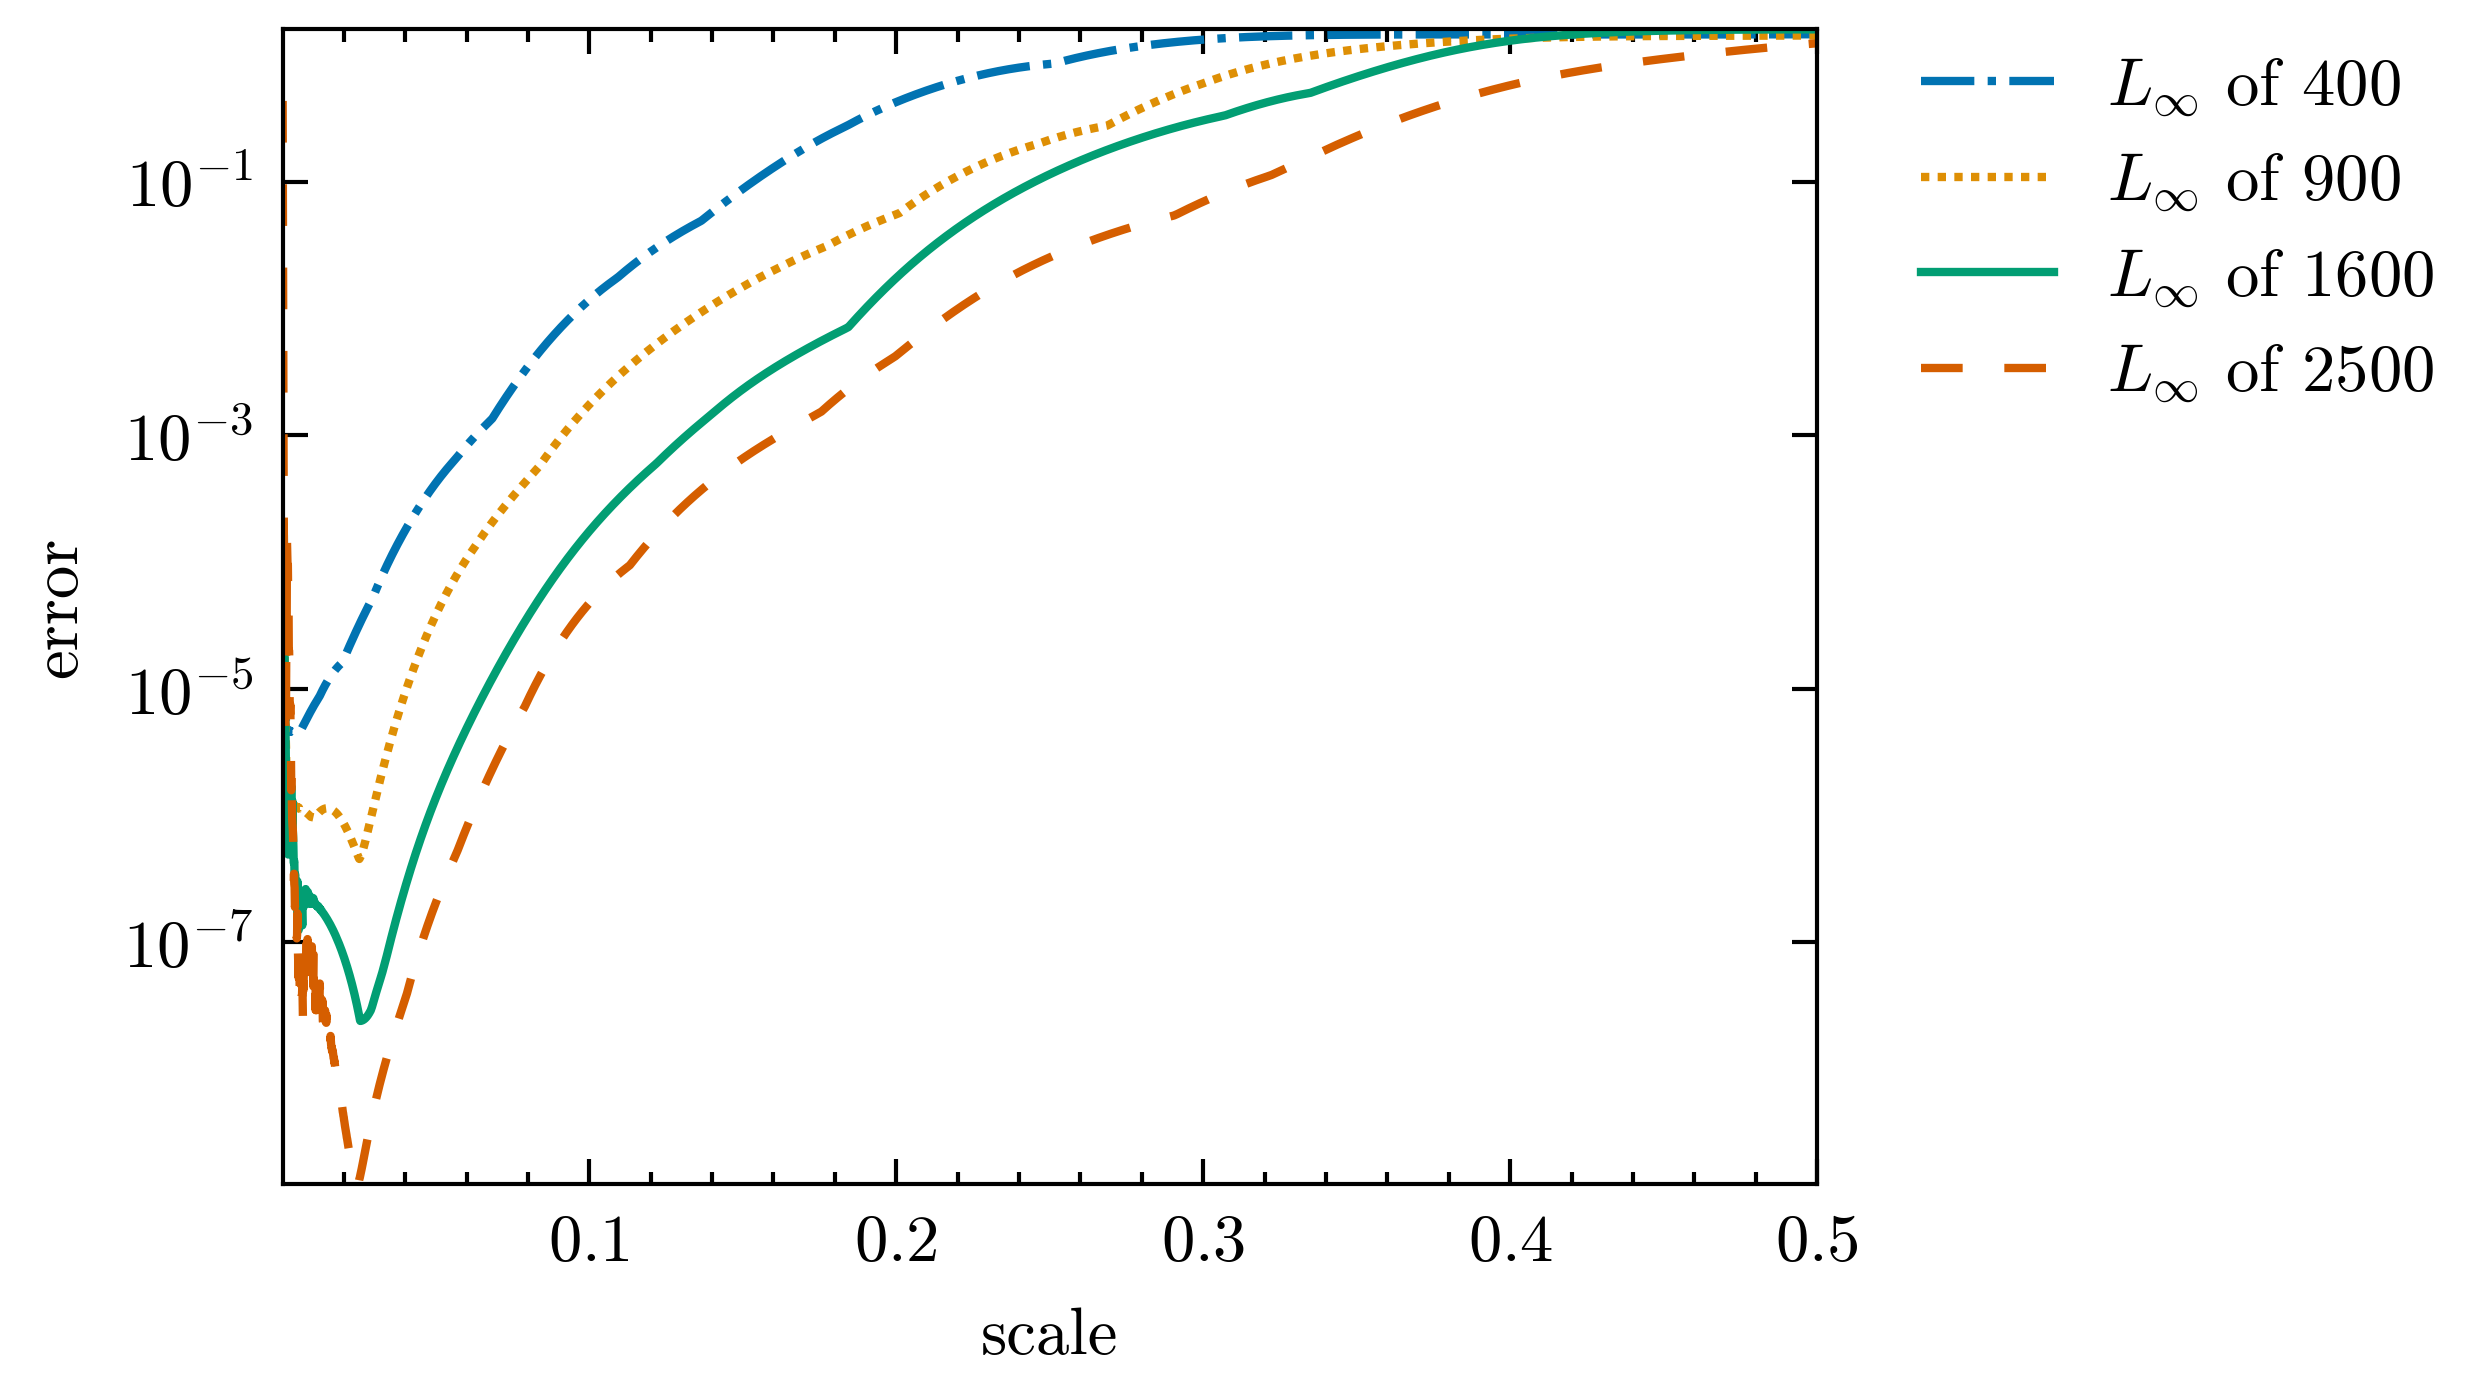

In [ ]:
import matplotlib.pyplot as plt
scales = np.asarray([i for i in range(1, stop+1)])*step

top_steps = stop

u_inftys_400 = u_inftys[:top_steps]
u_inftys_900 = u_inftys[top_steps:2*top_steps]
u_inftys_1600 = u_inftys[2*top_steps:3*top_steps]
u_inftys_2500 = u_inftys[3*top_steps:4*top_steps]

loss_inftys_400 = loss_inftys[:top_steps]
loss_inftys_900 = loss_inftys[top_steps:2*top_steps]
loss_inftys_1600 = loss_inftys[2*top_steps:3*top_steps]
loss_inftys_2500 = loss_inftys[3*top_steps:4*top_steps]

datas = []
data = np.stack((scales, u_inftys_400), 1)
datas.append(data)
data = np.stack((scales, u_inftys_900), 1)
datas.append(data)
data = np.stack((scales, u_inftys_1600), 1)
datas.append(data)
data = np.stack((scales, u_inftys_2500), 1)
datas.append(data)

data_labels =[]
data_labels.append('$L_{\infty}$ of 400')
data_labels.append('$L_{\infty}$ of 900')
data_labels.append('$L_{\infty}$ of 1600')
data_labels.append('$L_{\infty}$ of 2500')

file_name = root_path + '/' + path + '/u_infty_scale'
xy_labels = [r'$ho$', 'error']
from plot.line import plot_line
plot_line(datas,
              data_labels,
              xy_labels,
              title = None,
              file_name=file_name,
              xlog=False,
              ylog=True)
plt.show()

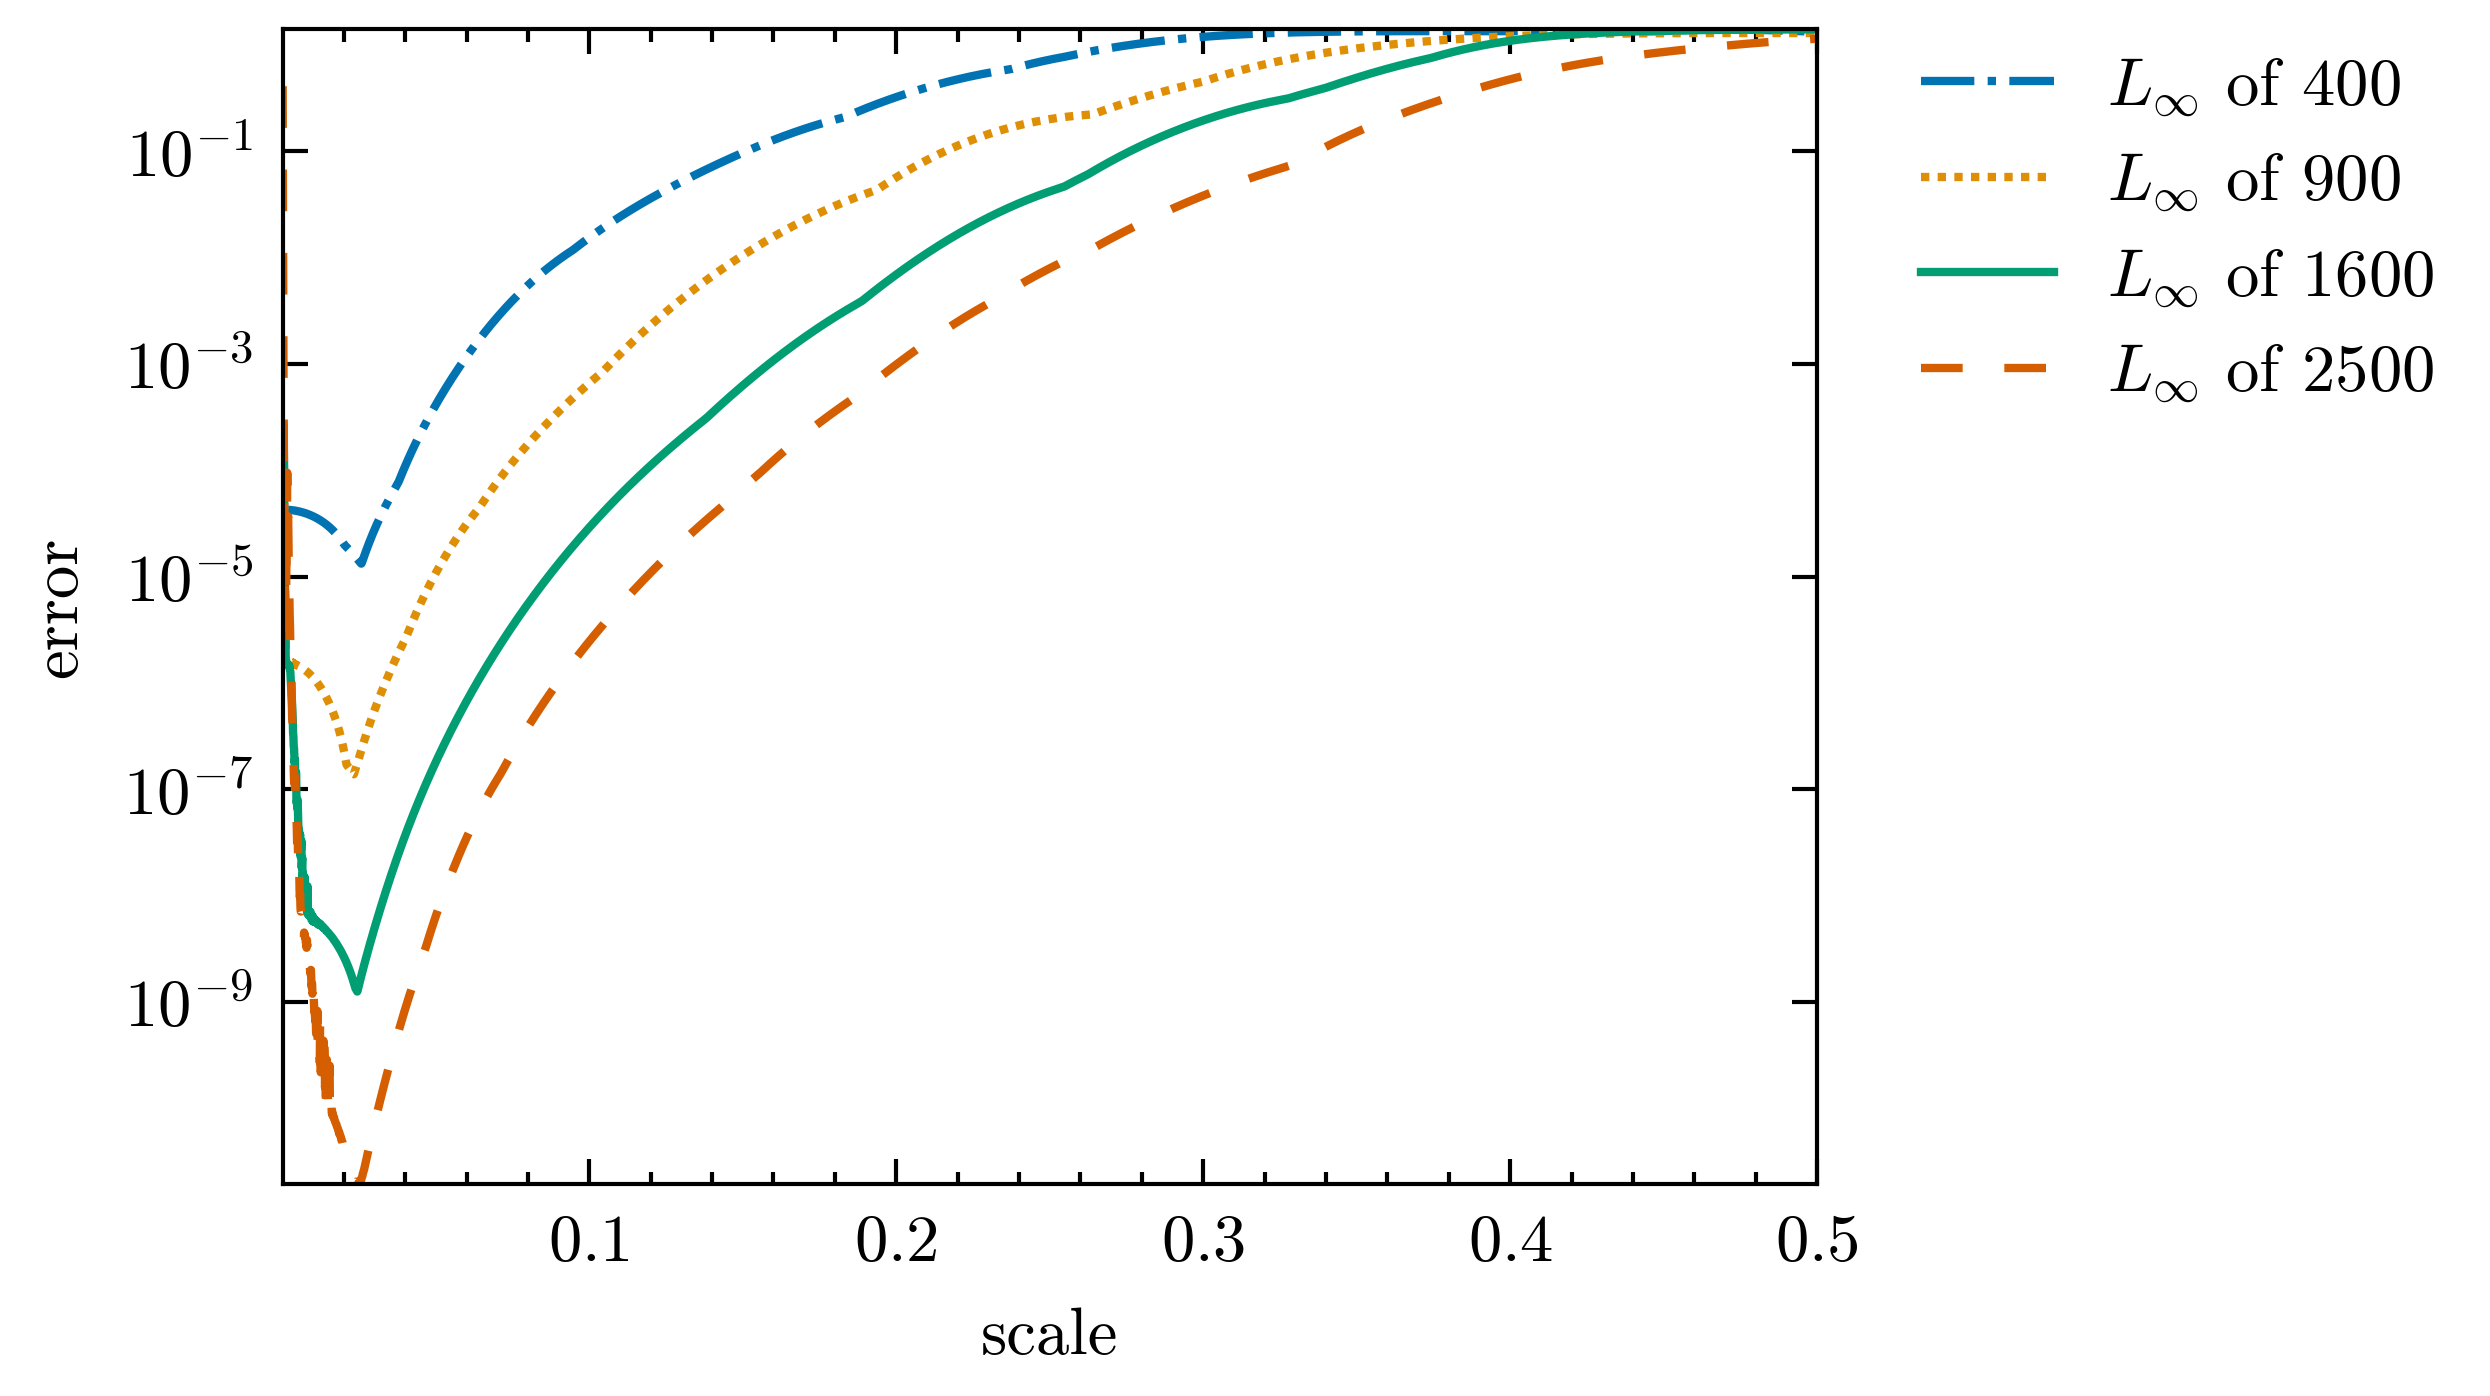

In [ ]:
import matplotlib.pyplot as plt
scales = np.asarray([i for i in range(1, stop+1)])*step

top_steps = stop

u_inftys_400 = u_inftys[:top_steps]
u_inftys_900 = u_inftys[top_steps:2*top_steps]
u_inftys_1600 = u_inftys[2*top_steps:3*top_steps]
u_inftys_2500 = u_inftys[3*top_steps:4*top_steps]

loss_inftys_400 = loss_inftys[:top_steps]
loss_inftys_900 = loss_inftys[top_steps:2*top_steps]
loss_inftys_1600 = loss_inftys[2*top_steps:3*top_steps]
loss_inftys_2500 = loss_inftys[3*top_steps:4*top_steps]

datas = []
data = np.stack((scales, loss_inftys_400), 1)
datas.append(data)
data = np.stack((scales, loss_inftys_900), 1)
datas.append(data)
data = np.stack((scales, loss_inftys_1600), 1)
datas.append(data)
data = np.stack((scales, loss_inftys_2500), 1)
datas.append(data)

data_labels =[]
data_labels.append('$L_{\infty}$ of 400')
data_labels.append('$L_{\infty}$ of 900')
data_labels.append('$L_{\infty}$ of 1600')
data_labels.append('$L_{\infty}$ of 2500')

file_name = root_path + '/' + path + '/loss_infty_scale'
xy_labels = [r'$ho$', 'error']
from plot.line import plot_line
plot_line(datas,
              data_labels,
              xy_labels,
              title = None,
              file_name=file_name,
              xlog=False,
              ylog=True)
plt.show()

In [19]:
idx = np.argmin(u_inftys_400)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(u_inftys_900)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(u_inftys_1600)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(u_inftys_2500)
min_scale = scales[idx]
print(min_scale)

0.0053
0.0251
0.025400000000000002
0.0246


In [20]:
idx = np.argmin(loss_inftys_400)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(loss_inftys_900)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(loss_inftys_1600)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(loss_inftys_2500)
min_scale = scales[idx]
print(min_scale)

0.0257
0.0233
0.0244
0.0252
